<a href="https://colab.research.google.com/github/TaoM1992/2020-msds691-example/blob/master/lahaus_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import re
import string
from transformers import AutoTokenizer, AutoModelForTokenClassification
import tensorflow as tf
from transformers import TFAutoModel

In [4]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-multilingual-cased-finetuned-conll03-spanish")


In [5]:
data = pd.read_csv('training-v2-2019-06-23T00_12_36.644Z.csv', names = ['description','label'])
data.head()

,description,label
0,440 en un nivel y 800 en otro nivel.\n\nse pue...,bad
1,"90-5414 Casa bifamiliar dos niveles, 3 alcoba...",bad
2,"90-54779 Excelente apartamento, en el exclusiv...",bad
3,Área: 5.000 Metros Totalmente Planos\n\nÁrea C...,good
4,"Proyecto de apartamentos de 1, 2 y 3 alcobas,...",good


In [6]:
def clean_data(df):
    lines = df.description.values
    clean_lines = []
    for line in lines:
        line = line.replace('\n\n', ' ').replace('\n', '').lower()
        line = re.sub('(mt2|m2|mts2|mtrs|m²|mtr2|mtrs2|mtr|metros|metros2|metro2|mtsrs)','mts', line)
        line = re.sub("([0-9]+)([a-z]+)", "\g<1> \g<2>", line)
        line = re.sub("([a-z]+)([0-9]+)", "\g<1> \g<2>", line)
        line = re.sub("\$ ?[0-9\.,]+", "MONEYAMNT", line)
        line = re.sub("[0-9]{1,3}.", "SHORTINT ", line)
        line = re.sub('['+string.punctuation+'¡'+']', ' ',line)
        line = line.replace('  ', ' ')
        clean_lines.append(line)
    df.description = np.array(clean_lines)
    df.label = df.label.map(lambda x: 1 if x=='good' else 0).values
    return df

In [7]:
data = clean_data(data)
data.head()

,description,label
0,SHORTINT en un nivel y SHORTINT en otro nivel ...,0
1,SHORTINT SHORTINT casa bifamiliar dos niveles ...,0
2,SHORTINT SHORTINT SHORTINT excelente apartamen...,0
3,área SHORTINT SHORTINT mts totalmente planos á...,1
4,proyecto de apartamentos de SHORTINT SHORTINT ...,1


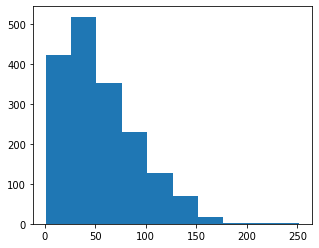

In [8]:
import matplotlib.pyplot as plt

line_len = [len(line.split()) for line in data.description.values] # number of words in each description
# distribution of words counts of each description
fig, ax = plt.subplots(figsize=(5,4)) 
ax.hist(line_len)
plt.show()

In [9]:
np.percentile(line_len, 95) # 95% of descriptions have less than 127 words, so I set max_length=120

127.0

In [10]:
Xids = np.zeros((len(data), 120)) 
Xmask = np.zeros((len(data), 120))

In [11]:
for i, sequence in enumerate(data.description):
    tokens = tokenizer.encode_plus(sequence, max_length=120, 
                               truncation=True, padding="max_length", 
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors='tf')
    Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [12]:
label = data.label.values.reshape(-1,1) 

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, label))

In [14]:
def map_func(input_ids, masks, label):
    for i in range(len(input_ids)):
        return {'input_ids':input_ids, 'attention_mask':masks}, label

In [15]:
ds = dataset.map(map_func)

In [16]:
for i in ds.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(120,), dtype=float64, numpy=
array([  101., 38702., 42622., 72286., 77261., 10110., 10119., 16398.,
         193., 38702., 42622., 72286., 77261., 10110., 16694., 16398.,
       10126., 12994., 26518., 10125., 38702., 42622., 72286., 77261.,
       10127., 19826., 10112., 23224., 25585., 18430.,   193., 15924.,
       19172., 10381., 11168., 10127., 19826., 10112., 38702., 42622.,
       72286., 77261.,   181., 10806.,   102.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,

In [17]:
# get train and valid set
shuf_data = ds.shuffle(10000).batch(32) 
ds_len = len(shuf_data)
split = .8
train = shuf_data.take(round(ds_len * split))
valid = shuf_data.skip(round(ds_len * split))

In [18]:
bert = TFAutoModel.from_pretrained("dbmdz/bert-base-multilingual-cased-finetuned-conll03-spanish")

Some layers from the model checkpoint at dbmdz/bert-base-multilingual-cased-finetuned-conll03-spanish were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-multilingual-cased-finetuned-conll03-spanish.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
input_ids = tf.keras.layers.Input(shape=(120,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(120,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False # freeze f.keras.layers.Dense(128, activation='relu')(X) to reduce trainable parameters

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 120)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 768)          0           tf_bert_model[1][0]        

In [32]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.BinaryCrossentropy()
accuracy = tf.keras.metrics.BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

In [33]:
history = model.fit(train, validation_data=valid, epochs=30)

Epoch 1/30
44/44 [==============================] - 27s 283ms/step - loss: 0.6078 - accuracy: 0.6687 - val_loss: 1.1223 - val_accuracy: 0.5736
Epoch 2/30
44/44 [==============================] - 9s 210ms/step - loss: 0.4796 - accuracy: 0.7892 - val_loss: 0.7172 - val_accuracy: 0.6607
Epoch 3/30
44/44 [==============================] - 9s 210ms/step - loss: 0.4064 - accuracy: 0.8176 - val_loss: 0.7141 - val_accuracy: 0.6577
Epoch 4/30
44/44 [==============================] - 9s 210ms/step - loss: 0.4033 - accuracy: 0.8352 - val_loss: 0.3958 - val_accuracy: 0.8438
Epoch 5/30
44/44 [==============================] - 9s 210ms/step - loss: 0.3676 - accuracy: 0.8401 - val_loss: 0.4349 - val_accuracy: 0.8108
Epoch 6/30
44/44 [==============================] - 9s 212ms/step - loss: 0.3258 - accuracy: 0.8644 - val_loss: 0.3793 - val_accuracy: 0.8378
Epoch 7/30
44/44 [==============================] - 9s 210ms/step - loss: 0.3221 - accuracy: 0.8667 - val_loss: 0.3224 - val_accuracy: 0.8649
Epoch